RITA TFR Analysis

In [2]:
import os
import glob
import mne
import numpy as np
from mne.time_frequency import tfr_morlet

In [2]:
print(os.getcwd())

c:\Users\Ania\Desktop\studia\courses\6sem\thesis\RM


In [6]:
# === Channel information ===
ch_rm = ['Fp1', 'Fpz', 'Fp2', 'AFz', 'AF3', 'AF7', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 
         'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'O1', 'C5', 
         'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'O2', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 
         'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']

In [7]:
def categorize_stimulus_label(stimulus):
    label = ""

    # Ambiguity
    if stimulus in ["125", "126", "127", "128"]:
        label += "A"
    else:
        label += "NA"

    # Word Order
    if stimulus in ["121", "122", "125", "126", "101", "102", "105", "106"]:
        label += "SF"
    elif stimulus in ["123", "124", "127", "128", "103", "104", "107", "108"]:
        label += "OF"
    else:
        label += "UNK"

    # Rhythm
    if stimulus in ["121", "123", "125", "127", "101", "103", "105", "107"]:
        label += "IR"
    elif stimulus in ["122", "124", "126", "128", "102", "104", "106", "108"]:
        label += "RR"
    else:
        label += "UNK"

    return label

In [ ]:
output_dir = "TFR_results_by_superset"
os.makedirs(output_dir, exist_ok=True)

freqs = np.arange(2, 40, 1)
n_cycles = freqs / 2.0  

file_paths = glob.glob(os.path.join("RM_1", "**", "*_epo.fif"), recursive=True)
file_paths += glob.glob(os.path.join("RM_2", "**", "*_epo.fif"), recursive=True)
print(f"Found {len(file_paths)} .fif files")

for file_path in file_paths:
    try:
        epochs = mne.read_epochs(file_path, preload=True, verbose=False)
    except Exception as e:
        print(f"Skipping {file_path}: {e}")
        continue

    participant = os.path.basename(file_path).split('_')[0]
    events = epochs.events 

    # Builds condition index map
    condition_epochs = {}
    for i, e in enumerate(events):
        event_code = str(e[2])
        label = categorize_stimulus_label(event_code)
        if label not in condition_epochs:
            condition_epochs[label] = []
        condition_epochs[label].append(i)

    # Computes TFR per condition label
    for label, indices in condition_epochs.items():
        if not indices:
            continue

        selected_epochs = epochs[indices]

        power = selected_epochs.compute_tfr(
            method="morlet",
            freqs=freqs,
            n_cycles=n_cycles,
            return_itc=False,
            average=True,
            verbose=False
            )

        tfr_data = power.data  # shape: (channels, freqs, times)
        save_path = os.path.join(output_dir, f"{participant}_{label}_tfr.npy")
        np.save(save_path, tfr_data)
        print(f"Saved TFR for {participant} - {label}, shape: {tfr_data.shape}")

Found 848 .fif files
Saved TFR for RM01 - NASFIR, shape: (58, 38, 1646)
Saved TFR for RM01 - NASFRR, shape: (58, 38, 1646)
Saved TFR for RM01 - NAOFIR, shape: (58, 38, 1646)
Saved TFR for RM01 - NAOFRR, shape: (58, 38, 1646)
Saved TFR for RM01 - NASFIR, shape: (58, 38, 1646)
Saved TFR for RM01 - NASFRR, shape: (58, 38, 1646)
Saved TFR for RM01 - NAOFIR, shape: (58, 38, 1646)
Saved TFR for RM01 - NAOFRR, shape: (58, 38, 1646)
Saved TFR for RM01 - NAUNKUNK, shape: (58, 38, 1646)
Saved TFR for RM01 - NAUNKUNK, shape: (58, 38, 1646)
Saved TFR for RM01 - NAUNKUNK, shape: (58, 38, 1646)
Saved TFR for RM01 - NAUNKUNK, shape: (58, 38, 1646)
Saved TFR for RM01 - NAUNKUNK, shape: (58, 38, 1646)
Saved TFR for RM01 - NAUNKUNK, shape: (58, 38, 1646)
Saved TFR for RM01 - NAUNKUNK, shape: (58, 38, 1646)
Saved TFR for RM01 - NAUNKUNK, shape: (58, 38, 1646)
Saved TFR for RM02 - NASFIR, shape: (58, 38, 1646)
Saved TFR for RM02 - NASFRR, shape: (58, 38, 1646)
Saved TFR for RM02 - NAOFIR, shape: (58, 38, 

In [5]:
from collections import Counter
import glob, os

files = glob.glob("TFR_results_by_superset/*_tfr.npy")
labels = [os.path.basename(f).split("_")[1] for f in files]
counts = Counter(labels)

for cond, n in counts.items():
    print(f"{cond}: {n} participants")

AOFIR: 28 participants
AOFRR: 28 participants
ASFIR: 28 participants
ASFRR: 28 participants
NAOFIR: 28 participants
NAOFRR: 28 participants
NASFIR: 28 participants
NASFRR: 28 participants
NAUNKUNK: 28 participants
XA: 28 participants
XF: 28 participants
XR: 28 participants


In [ ]:
from glob import glob

tfr_dir = "TFR_results_by_superset"
output_dir = "TFR_contrasts_Ambiguity"
os.makedirs(output_dir, exist_ok=True)

word_orders = ["SF", "OF"]
rhythms = ["IR", "RR"]


contrast_pairs = [(f"A{wo}{rh}", f"NA{wo}{rh}") for wo in word_orders for rh in rhythms]

for cond_A, cond_B in contrast_pairs:
    print(f"\n Running contrast: {cond_A} vs {cond_B}")

    tfr_diffs = []
    tfr_A_files = glob(os.path.join(tfr_dir, f"*_{cond_A}_tfr.npy"))

    for path_A in tfr_A_files:
        participant = os.path.basename(path_A).split("_")[0]
        path_B = os.path.join(tfr_dir, f"{participant}_{cond_B}_tfr.npy")

        if not os.path.exists(path_B):
            print(f"Skipping {participant} — missing {cond_B}")
            continue

        A = np.load(path_A)
        B = np.load(path_B)

        if A.shape != B.shape:
            print(f"Shape mismatch for {participant}")
            continue

        diff = A - B
        tfr_diffs.append(diff)

    if not tfr_diffs:
        print("No valid participants found for this contrast.")
        continue

    # Stacks and averages
    tfr_diffs = np.stack(tfr_diffs, axis=0)  # (N, C, F, T)
    avg_diff = np.mean(tfr_diffs, axis=0)    # (C, F, T)

    fname = f"TFRdiff_{cond_A}_vs_{cond_B}.npy"
    np.save(os.path.join(output_dir, fname), avg_diff)
    print(f"Saved contrast to: {fname}, shape: {avg_diff.shape}")



 Running contrast: ASFIR vs NASFIR
Saved contrast to: TFRdiff_ASFIR_vs_NASFIR.npy, shape: (58, 38, 1051)

 Running contrast: ASFRR vs NASFRR
Saved contrast to: TFRdiff_ASFRR_vs_NASFRR.npy, shape: (58, 38, 1051)

 Running contrast: AOFIR vs NAOFIR
Saved contrast to: TFRdiff_AOFIR_vs_NAOFIR.npy, shape: (58, 38, 1051)

 Running contrast: AOFRR vs NAOFRR
Saved contrast to: TFRdiff_AOFRR_vs_NAOFRR.npy, shape: (58, 38, 1051)


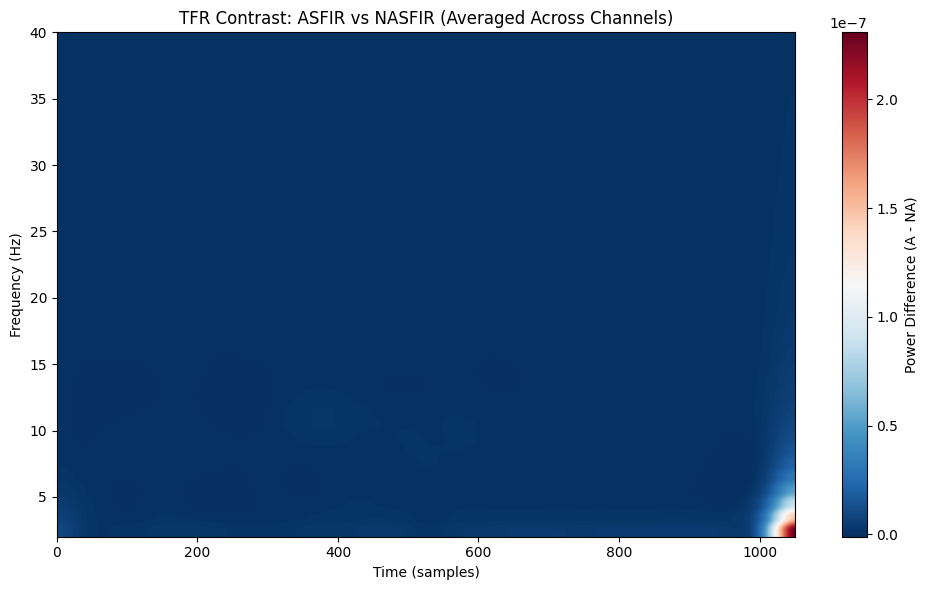

In [ ]:
import matplotlib.pyplot as plt


contrast_file = "TFR_contrasts_Ambiguity/TFRdiff_ASFIR_vs_NASFIR.npy"
tfr = np.load(contrast_file)  # shape: (channels, freqs, times)

# Average over channels
avg_tfr = np.mean(tfr, axis=0)  # shape: (freqs, times)


plt.figure(figsize=(10, 6))
plt.imshow(avg_tfr, aspect='auto', origin='lower',
           extent=[0, avg_tfr.shape[1], 2, 40], cmap='RdBu_r')
plt.colorbar(label='Power Difference (A - NA)')
plt.title("TFR Contrast: ASFIR vs NASFIR (Averaged Across Channels)")
plt.xlabel("Time (samples)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()



In [ ]:

cond_A = "ASFIR"
cond_B = "NASFIR"
tfr_dir = "TFR_results_by_superset"

A_paths = glob(os.path.join(tfr_dir, f"*_{cond_A}_tfr.npy"))
B_paths = [p.replace(cond_A, cond_B) for p in A_paths]

TFR_A_all = []
TFR_B_all = []
participants = []

for path_A, path_B in zip(A_paths, B_paths):
    if not os.path.exists(path_B):
        continue
    A = np.load(path_A)
    B = np.load(path_B)

    if A.shape != B.shape:
        continue

    TFR_A_all.append(A)
    TFR_B_all.append(B)
    participants.append(os.path.basename(path_A).split("_")[0])

# Stack to 4D: (P, C, F, T)
TFR_A_all = np.stack(TFR_A_all)
TFR_B_all = np.stack(TFR_B_all)

print(f"Loaded {TFR_A_all.shape[0]} participants.")

Loaded 28 participants.


In [ ]:
TFR_A_mean = TFR_A_all.mean(axis=0)  # (C, F, T)
TFR_B_mean = TFR_B_all.mean(axis=0)
TFR_diff_mean = TFR_A_mean - TFR_B_mean  
TFR_ratio_mean = TFR_A_mean / (TFR_B_mean + 1e-10)

In [ ]:
from scipy.stats import ttest_rel


cond_A = "ASFIR"
cond_B = "NASFIR"
tfr_dir = "TFR_results_by_superset"
output_dir = f"TFR_contrast_plots_{cond_A}_vs_{cond_B}"
os.makedirs(output_dir, exist_ok=True)

freq_range = (4, 8)       
time_range = (100, 300)   

paths_A = glob(os.path.join(tfr_dir, f"*_{cond_A}_tfr.npy"))
paths_B = [p.replace(cond_A, cond_B) for p in paths_A]

TFR_A_all, TFR_B_all, participants = [], [], []

for path_A, path_B in zip(paths_A, paths_B):
    if not os.path.exists(path_B):
        continue
    A = np.load(path_A)
    B = np.load(path_B)
    if A.shape != B.shape:
        continue
    TFR_A_all.append(A)
    TFR_B_all.append(B)
    participants.append(os.path.basename(path_A).split("_")[0])

TFR_A_all = np.stack(TFR_A_all)  # (P, C, F, T)
TFR_B_all = np.stack(TFR_B_all)

n_participants, n_channels, n_freqs, n_times = TFR_A_all.shape
print(f"Loaded {n_participants} participants")

channel_names = ch_rm[:n_channels]  

f_idx = np.logical_and(np.arange(n_freqs) >= freq_range[0],
                       np.arange(n_freqs) <= freq_range[1])
t_idx = np.logical_and(np.arange(n_times) >= time_range[0],
                       np.arange(n_times) <= time_range[1])

for ch_idx, ch_name in enumerate(channel_names):
    A_mean = TFR_A_all[:, ch_idx].mean(axis=0)  # (F, T)
    B_mean = TFR_B_all[:, ch_idx].mean(axis=0)
    diff_mean = A_mean - B_mean

    box_A = TFR_A_all[:, ch_idx][:, f_idx][:, :, t_idx].mean(axis=(1, 2))
    box_B = TFR_B_all[:, ch_idx][:, f_idx][:, :, t_idx].mean(axis=(1, 2))

    t_stat, p_val = ttest_rel(box_A, box_B)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(A_mean, aspect='auto', origin='lower', cmap='viridis')
    axs[0].set_title(f"{cond_A}")
    axs[0].set_ylabel("Freq"); axs[0].set_xlabel("Time")

    axs[1].imshow(B_mean, aspect='auto', origin='lower', cmap='viridis')
    axs[1].set_title(f"{cond_B}")

    axs[2].imshow(diff_mean, aspect='auto', origin='lower', cmap='RdBu_r')
    axs[2].set_title("Diff (A - B)")

    fig.suptitle(f"{ch_name} | t = {t_stat:.2f}, p = {p_val:.4f}", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{ch_name}_TFR_{cond_A}_vs_{cond_B}.png"))
    plt.close()

print(f"Plots saved to: {output_dir}")

Loaded 28 participants
Plots saved to: TFR_contrast_plots_ASFIR_vs_NASFIR


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.backends.backend_pdf import PdfPages

plot_dir = "TFR_contrast_plots_ASFIR_vs_NASFIR"
channels_to_plot = ch_rm  


plots_per_page = 12
ncols = 3
nrows = plots_per_page // ncols

with PdfPages(output_pdf) as pdf:
    for i in range(0, len(channels_to_plot), plots_per_page):
        fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
        axs = axs.flatten()

        for j, ch_name in enumerate(channels_to_plot[i:i + plots_per_page]):
            ax = axs[j]
            image_path = os.path.join(plot_dir, f"{ch_name}_TFR_ASFIR_vs_NASFIR.png")

            if os.path.exists(image_path):
                img = imread(image_path)
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(ch_name)
            else:
                ax.axis("off")
                ax.set_title(f"{ch_name} (missing)")

        # Hide any unused subplots on this page
        for k in range(j + 1, len(axs)):
            axs[k].axis("off")

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved to: {output_pdf}")


PDF saved to: TFR_all_channels_ASFIR_vs_NASFIR.pdf


In [8]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Defines the base label combinations
xfxr_combos = ["SFIR", "SFRR", "OFIR", "OFRR"]
ambiguous_labels = [f"A{tag}" for tag in xfxr_combos]
non_ambiguous_labels = [f"NA{tag}" for tag in xfxr_combos]

tfr_dir = "TFR_results_by_superset"
output_dir = "TFR_contrast_plots_AXFXR_vs_NAXFXR"
os.makedirs(output_dir, exist_ok=True)

freq_range = (4, 8)
time_range = (100, 300)

paths = glob.glob(os.path.join(tfr_dir, f"*_{ambiguous_labels[0]}_tfr.npy"))
participants = [os.path.basename(p).split("_")[0] for p in paths]

TFR_A_all, TFR_B_all = [], []

for participant in participants:
    tfrs_A = []
    tfrs_B = []

    for amb_label, nonamb_label in zip(ambiguous_labels, non_ambiguous_labels):
        path_A = os.path.join(tfr_dir, f"{participant}_{amb_label}_tfr.npy")
        path_B = os.path.join(tfr_dir, f"{participant}_{nonamb_label}_tfr.npy")

        if not (os.path.exists(path_A) and os.path.exists(path_B)):
            continue

        A = np.load(path_A)
        B = np.load(path_B)

        if A.shape != B.shape:
            continue

        tfrs_A.append(A)
        tfrs_B.append(B)

    if tfrs_A and tfrs_B:
        TFR_A_all.append(np.mean(tfrs_A, axis=0))
        TFR_B_all.append(np.mean(tfrs_B, axis=0))

TFR_A_all = np.stack(TFR_A_all)  # (P, C, F, T)
TFR_B_all = np.stack(TFR_B_all)

n_participants, n_channels, n_freqs, n_times = TFR_A_all.shape
channel_names = ch_rm[:n_channels]

f_idx = np.logical_and(np.arange(n_freqs) >= freq_range[0],
                       np.arange(n_freqs) <= freq_range[1])
t_idx = np.logical_and(np.arange(n_times) >= time_range[0],
                       np.arange(n_times) <= time_range[1])


for ch_idx, ch_name in enumerate(channel_names):
    A_mean = TFR_A_all[:, ch_idx].mean(axis=0)
    B_mean = TFR_B_all[:, ch_idx].mean(axis=0)
    diff_mean = A_mean - B_mean

    box_A = TFR_A_all[:, ch_idx][:, f_idx][:, :, t_idx].mean(axis=(1, 2))
    box_B = TFR_B_all[:, ch_idx][:, f_idx][:, :, t_idx].mean(axis=(1, 2))
    t_stat, p_val = ttest_rel(box_A, box_B)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(A_mean, aspect='auto', origin='lower', cmap='viridis')
    axs[0].set_title("Ambiguous_XFXR")

    axs[1].imshow(B_mean, aspect='auto', origin='lower', cmap='viridis')
    axs[1].set_title("NonAmbiguous_XFXR")

    axs[2].imshow(diff_mean, aspect='auto', origin='lower', cmap='RdBu_r')
    axs[2].set_title("Diff (A - NA)")

    fig.suptitle(f"{ch_name} | t = {t_stat:.2f}, p = {p_val:.4f}", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{ch_name}_TFR_AmbiguousXFXR_vs_NonAmbiguousXFXR.png"))
    plt.close()

print(f"Plots saved in: {output_dir}")


Plots saved in: TFR_contrast_plots_AXFXR_vs_NAXFXR
